In [1]:
from google.colab import files

uploaded = files.upload()

Saving test_vocabulary.txt to test_vocabulary.txt


In [2]:

!wget -c https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.uk.300.vec.gz
!gunzip -k cc.uk.300.vec.gz

--2025-06-06 06:49:58--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.uk.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.163.189.51, 3.163.189.14, 3.163.189.96, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.163.189.51|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1257595219 (1.2G) [binary/octet-stream]
Saving to: ‘cc.uk.300.vec.gz’

cc.uk.300.vec.gz    100%[===================>]   1.17G  62.0MB/s    in 21s     

2025-06-06 06:50:20 (56.8 MB/s) - ‘cc.uk.300.vec.gz’ saved [1257595219/1257595219]



In [3]:
import numpy as np

word_vectors = {}

with open("cc.uk.300.vec", "r", encoding="utf-8") as f:
    next(f)  # Пропускаємо перший рядок з розмірністю
    for line in f:
        parts = line.rstrip().split(' ')
        word = parts[0]
        vec = np.array(parts[1:], dtype=float)
        word_vectors[word] = vec

print(f"Завантажено {len(word_vectors)} векторів")

Завантажено 2000000 векторів


In [4]:

quad_file = "test_vocabulary.txt"

raw_quads = []
with open(quad_file, "r", encoding="utf-8") as f:
    for line in f:
        if ':' in line and 'adjective-adverb' in line:
            continue  # пропускаємо заголовок
        parts = line.strip().split('\t')
        if len(parts) == 4:
            raw_quads.append(tuple(parts))

print(f"Знайдено четвірок у файлі: {len(raw_quads)}")

Знайдено четвірок у файлі: 23970


In [5]:
valid_quads = []

for adj1, adv1, adj2, adv2 in raw_quads:
    if adj1 in word_vectors and adv1 in word_vectors and adj2 in word_vectors and adv2 in word_vectors:
        valid_quads.append((adj1, adv1, adj2, adv2))

print(f"Кількість валідних четвірок: {len(valid_quads)}")

Кількість валідних четвірок: 17000


In [6]:

def cosine_similarity(vec1, vec2):
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

# Аналогія через cosine: adj1 : adv1 = adj2 : ?
def find_best_adv_cosine(adj1, adv1, adj2, word_vectors):
    target_vec = word_vectors[adv1] - word_vectors[adj1] + word_vectors[adj2]
    best_score = -1
    best_word = None
    for word, vec in word_vectors.items():
        if word in {adj1, adv1, adj2}:
            continue
        sim = cosine_similarity(target_vec, vec)
        if sim > best_score:
            best_score = sim
            best_word = word
    return best_word, best_score

In [8]:
import random
from tqdm import tqdm


sample_quads = random.sample(valid_quads, 1000)


limited_words = list(word_vectors.keys())[:100000]
limited_vectors = {w: word_vectors[w] for w in limited_words}


def find_best_adv_cosine_fast(adj1, adv1, adj2):
    target_vec = word_vectors[adv1] - word_vectors[adj1] + word_vectors[adj2]
    best_score = -1
    best_word = None
    for word in limited_words:
        if word in {adj1, adv1, adj2}:
            continue
        sim = cosine_similarity(target_vec, word_vectors[word])
        if sim > best_score:
            best_score = sim
            best_word = word
    return best_word

correct = 0

print("Обчислення точності на 1000 четвірках...")
for quad in tqdm(sample_quads):
    adj1, adv1, adj2, adv2 = quad
    predicted = find_best_adv_cosine_fast(adj1, adv1, adj2)
    if predicted == adv2:
        correct += 1

accuracy = correct / len(sample_quads)
print(f"\n✅ Точність на тестовій вибірці: {accuracy:.4f} ({correct} з {len(sample_quads)})")

Обчислення точності на 1000 четвірках...


100%|██████████| 1000/1000 [14:51<00:00,  1.12it/s]


✅ Точність на тестовій вибірці: 0.3230 (323 з 1000)


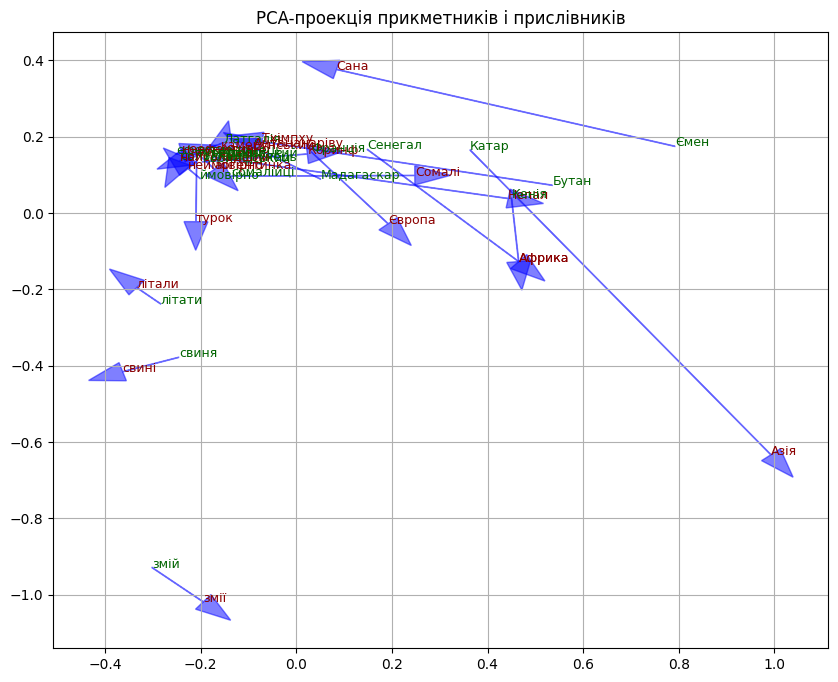

In [11]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Випадкові 20 пар
sample_pairs = random.sample(valid_quads, 20)

# Збираємо слова і вектори
words = []
vectors = []
for adj, adv, _, _ in sample_pairs:
    if adj in word_vectors and adv in word_vectors:
        words.extend([adj, adv])
        vectors.append(word_vectors[adj])
        vectors.append(word_vectors[adv])

# PCA: 300 → 2 виміри
pca = PCA(n_components=2)
projected = pca.fit_transform(vectors)

# Візуалізація
plt.figure(figsize=(10, 8))
for i in range(0, len(projected), 2):
    adj = words[i]
    adv = words[i+1]
    x1, y1 = projected[i]
    x2, y2 = projected[i+1]

    # Стрілка: прикметник → прислівник
    plt.arrow(x1, y1, x2 - x1, y2 - y1, head_width=0.05, color='blue', alpha=0.5)

    # Тексти
    plt.text(x1, y1, adj, fontsize=9, color='darkgreen')
    plt.text(x2, y2, adv, fontsize=9, color='darkred')

plt.title("PCA-проекція прикметників і прислівників")
plt.grid(True)
plt.show()

In [13]:
import json

sample_size = 1000  # або більше, як хочеш
sample_quads = random.sample(valid_quads, sample_size)

results = []
correct = 0

print(f"🔍 Тестування на {sample_size} четвірках...")

for adj1, adv1, adj2, adv2 in tqdm(sample_quads):
    predicted = find_best_adv_cosine_fast(adj1, adv1, adj2)
    is_correct = predicted == adv2
    if is_correct:
        correct += 1
    results.append({
        "adj1": adj1,
        "adv1": adv1,
        "adj2": adj2,
        "expected_adv2": adv2,
        "predicted_adv2": predicted,
        "correct": is_correct
    })

accuracy = correct / sample_size
print(f"\n✅ Точність: {accuracy:.4f} ({correct} з {sample_size})")

# Збереження в JSON
with open("analogy_results.json", "w", encoding="utf-8") as f:
    json.dump(results, f, ensure_ascii=False, indent=2)

print("📁 Результати збережено в файл: analogy_results.json")

🔍 Тестування на 1000 четвірках...


100%|██████████| 1000/1000 [15:16<00:00,  1.09it/s]


✅ Точність: 0.3450 (345 з 1000)
📁 Результати збережено в файл: analogy_results.json
